[*********************100%***********************]  1 of 1 completed


No missing values in the data.
ADF Statistic: -0.8945070855884606
p-value: 0.7897759306181455
Critical Values: {'1%': -3.432291925223487, '5%': -2.862398029645529, '10%': -2.567226745854943}
Differenced data with lag 1:
Date
2010-06-30   -0.004000
2010-07-01   -0.124667
2010-07-02   -0.184000
2010-07-06   -0.206000
2010-07-07   -0.020667
Name: Adj Close, dtype: float64


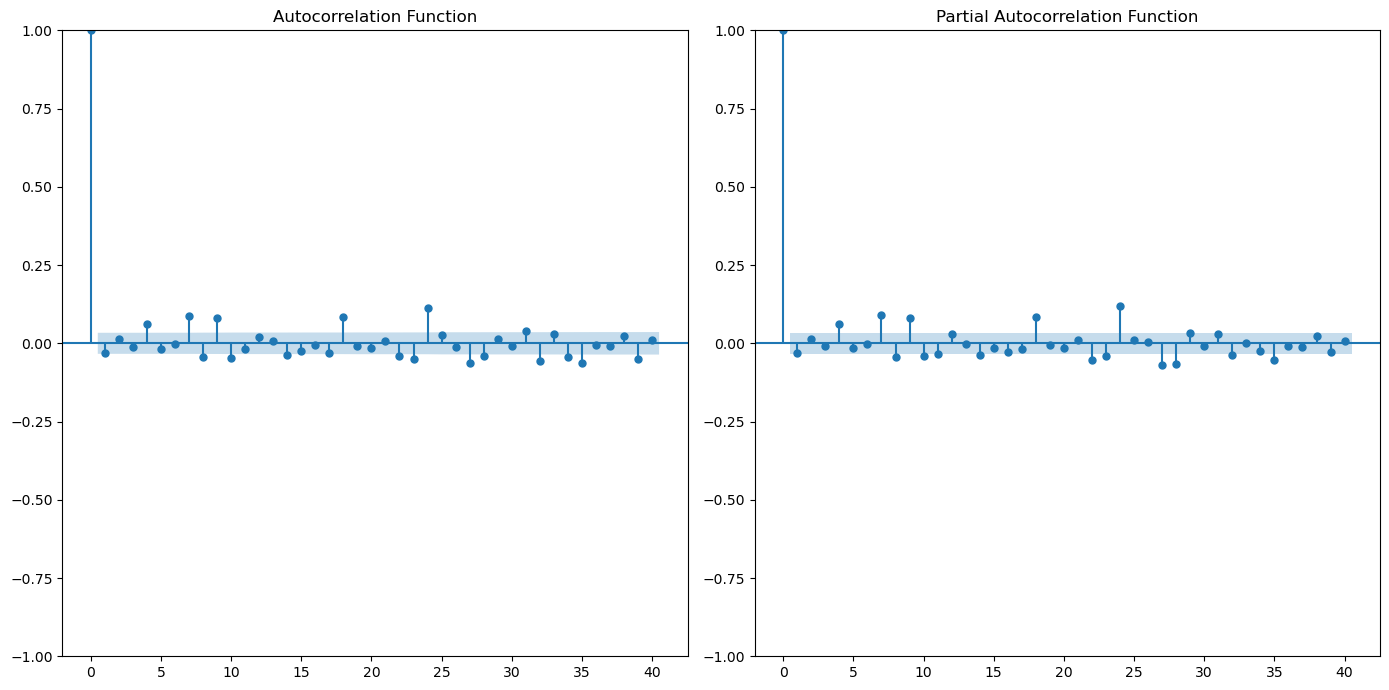

Finding the best ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=14541.155, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=13680.305, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=14539.157, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=13181.609, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=12983.709, Time=0.24 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=12970.894, Time=0.34 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=12840.214, Time=0.43 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=12838.215, Time=0.34 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=12968.898, Time=0.32 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(4,2,1)(0,0

KeyboardInterrupt: 

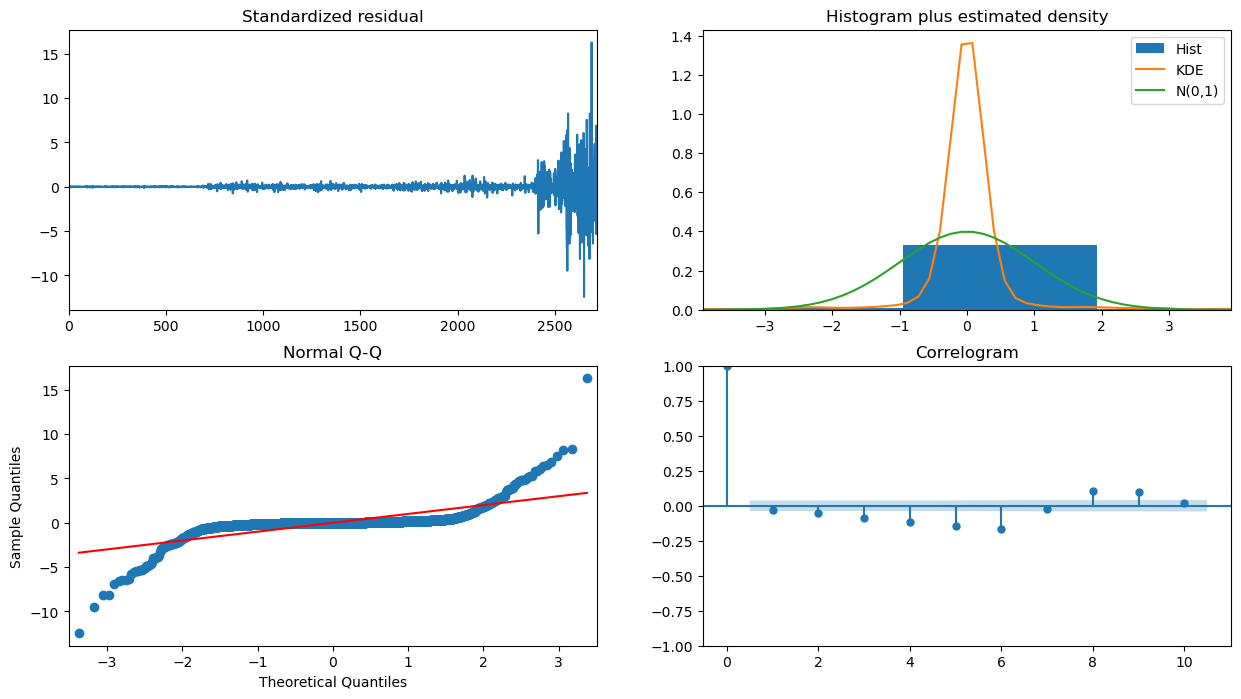

In [6]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

class StockForecasting:
    def __init__(self, symbol, start, end, p_value_threshold=0.05):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.p_value_threshold = p_value_threshold
        self.data = self.download_data()
        self.data = self.sanity_check(self.data)
        self.diff_data = None
        self.best_param = None
        self.model_fit = None

    def download_data(self):
        """Download stock data from Yahoo Finance."""
        data = yf.download(self.symbol, start=self.start, end=self.end, interval='1d')[['Adj Close']]
        return data

    def sanity_check(self, data):
        """Check for missing values and handle them."""
        if data.isnull().values.any():
            print("Missing values found.")
            data.fillna(method='ffill', inplace=True)
            print("Missing values have been forward-filled.")
        else:
            print("No missing values in the data.")
        return data

    def check_stationarity(self, df):
        """Check for stationarity of the data using the ADF test."""
        adf_result = adfuller(df)
        p_value = adf_result[1]
        print(f"ADF Statistic: {adf_result[0]}")
        print(f"p-value: {adf_result[1]}")
        print(f"Critical Values: {adf_result[4]}")
        return p_value < 0.05

    def apply_differencing(self, lag=1):
        """Apply differencing to the series."""
        self.diff_data = self.data['Adj Close'].diff(periods=lag).dropna()
        print(f"Differenced data with lag {lag}:")
        print(self.diff_data.head())
        return self.diff_data

    def plot_acf_pacf(self, diff_data):
        """Plot ACF and PACF for the differenced data."""
        plt.figure(figsize=(14, 7))
        plt.subplot(121)
        plot_acf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Autocorrelation Function')
        plt.subplot(122)
        plot_pacf(diff_data, ax=plt.gca(), lags=40)
        plt.title('Partial Autocorrelation Function')
        plt.tight_layout()
        plt.show()

    def find_best_arima_parameters(self):
        """Find the best ARIMA parameters using auto_arima based on AIC and significant terms."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        print("Finding the best ARIMA model...")

        # Use auto_arima to get the initial best model based on AIC
        model = pm.auto_arima(data_train['Adj Close'], seasonal=False, trace=True,
                               error_action='ignore', suppress_warnings=True,
                               stepwise=True, criterion='aic')
        self.best_param = model.order
        print(f"Initial best model based on AIC: {self.best_param}")
        print(model.summary())
        model.plot_diagnostics(figsize=(15,8))


        # Fit the model and check p-values
        arima_model = ARIMA(data_train['Adj Close'], order=self.best_param)
        self.model_fit = arima_model.fit()

        p_values = self.model_fit.pvalues
        print(f"P-values for model terms: {p_values}")

        # Validate model by ensuring no insignificant terms (based on p-value threshold)
        if all(p_values < self.p_value_threshold):
            print(f"Selected model {self.best_param} passes the p-value threshold check.")
        else:
            print(f"Some terms in the model {self.best_param} are not significant.")
            # Use stepwise search to refine
            refined_model = pm.auto_arima(data_train['Adj Close'], seasonal=False,
                                           trace=True, error_action='ignore',
                                           suppress_warnings=True, stepwise=True,
                                           criterion='aic', alpha=self.p_value_threshold)
            refined_model.plot_diagnostics(figsize=(15,8))
            self.best_param = refined_model.order
            self.model_fit = refined_model.fit()
            print(f"Refined model after checking p-values: {self.best_param}")
            print(self.model_fit.summary())

        return self.best_param

    def get_predicted_prices(self, close_prices):
        """Get predicted prices using the best ARIMA model."""
        best_model = ARIMA(close_prices.values, order=self.best_param)
        best_model_fit = best_model.fit(method_kwargs={"warn_convergence": False})
        predictions = best_model_fit.forecast(steps=1)[0]
        return predictions

    def run_forecasting(self):
        """Run the forecasting process and evaluate the strategy."""
        split = int(len(self.data) * 0.8)  # Adjusted split for better training/testing
        data_train = self.data[:split]
        data_test = self.data[split:]

        predictions = []
        for i in range(len(data_test['Adj Close'])):
            current_data = pd.concat([data_train['Adj Close'], data_test['Adj Close'].iloc[:i]])
            next_pred = self.get_predicted_prices(current_data)
            predictions.append(next_pred)

        predictions_df = pd.DataFrame(predictions, columns=['predicted_price'])
        predictions_df.index = data_test.index
        data_test = pd.concat([data_test, predictions_df], axis=1)

        # Generate signals and returns
        data_test['predicted_returns'] = data_test['predicted_price'].pct_change()
        data_test['actual_returns'] = data_test['Adj Close'].pct_change()
        data_test.dropna(inplace=True)
        data_test['signal'] = np.where(data_test['predicted_returns'] >= 0, 1, -1)
        data_test['strategy_returns'] = data_test['signal'] * data_test['actual_returns']
        data_test['cumulative_returns'] = np.cumprod(data_test['strategy_returns'] + 1)

        # Buy and hold returns
        buy_and_hold_returns = (1 + data_test['actual_returns']).cumprod()

        # Error Metrics
        mse = mean_squared_error(data_test['Adj Close'], data_test['predicted_price'])
        mae = mean_absolute_error(data_test['Adj Close'], data_test['predicted_price'])
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((data_test['Adj Close'] - data_test['predicted_price']) / data_test['Adj Close'])) * 100

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape}%")



        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(data_test['cumulative_returns'], label='Predicted Cumulative Returns')
        plt.plot(buy_and_hold_returns, label='Buy and Hold Cumulative Returns')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.title('Predicted vs Buy and Hold Cumulative Returns')
        plt.legend()
        plt.show()

        return data_test

    def simulate_forecasts(self, num_simulations, forecast_periods):
        """Simulate forecasts for the specified number of periods and simulations."""
        residuals = self.model_fit.resid
        noise_distribution = residuals / np.std(residuals)  # Standardized residuals
        forecast_results = np.zeros((num_simulations, forecast_periods))

        # Simulate forecasts
        for sim in range(num_simulations):
            simulated_noise = np.random.choice(noise_distribution, size=forecast_periods, replace=True)
            forecasted_values = self.model_fit.forecast(steps=forecast_periods) + simulated_noise
            forecast_results[sim, :] = forecasted_values

        return forecast_results

    def percent_simulations_exceeding_value(self, threshold, num_simulations, forecast_periods):
        """Calculate the percentage of simulations exceeding a threshold in each forecast period."""
        forecast_results = self.simulate_forecasts(num_simulations, forecast_periods)
        print(forecast_results) #forecasting the prices with respect to total number of periods 

        # Calculate percentage of simulations exceeding the threshold in each period
        exceed_percentages = (forecast_results > threshold).mean(axis=0) * 100

        # Generate future dates for the forecasts
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        future_dates = pd.date_range(start=data_train.index[-1] + pd.Timedelta(days=1), periods=forecast_periods, freq='B')

        # Create a DataFrame with forecast period and percentage of simulations exceeding threshold
        exceed_df = pd.DataFrame({
            'Date': future_dates,
            'Percentage Exceeding Threshold': exceed_percentages
        })

        return exceed_df

    def plot_simulated_forecasts(self, num_simulations, forecast_periods):
        """Plot simulated forecasts along with actual values."""
        split = int(len(self.data) * 0.8)
        data_train = self.data[:split]
        
        # Get simulated forecasts
        forecast_results = self.simulate_forecasts(num_simulations, forecast_periods)
        
        # Generate future dates for the forecasts
        future_dates = pd.date_range(start=data_train.index[-1] + pd.Timedelta(days=1), periods=forecast_periods, freq='B')

        # Plot actuals and simulated forecasts
        plt.figure(figsize=(14, 7))
        plt.plot(self.data['Adj Close'], label='Actual Prices', color='blue')
        
        for i in range(num_simulations):
            plt.plot(future_dates, forecast_results[i, :], color='red', alpha=0.1)

        plt.title(f'Simulated Forecasts for {self.symbol}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()


"""
AAPL - Apple Inc.
MSFT - Microsoft Corporation
GOOGL - Alphabet Inc. (Class A)
AMZN - Amazon.com, Inc.
TSLA - Tesla, Inc.
FB - Meta Platforms, Inc. (formerly Facebook)
BRK.B - Berkshire Hathaway Inc. (Class B)
NFLX - Netflix, Inc.
DIS - The Walt Disney Company

"""

# Example usage:
if __name__ == "__main__":
    symbol = 'TSLA'
    start = '2010-01-01'
    end = '2023-12-31'
    p_value_threshold = 0.05  # Set a custom p-value threshold
    
    stock_forecast = StockForecasting(symbol, start, end, p_value_threshold)
    
    # Check if the series is stationary
    is_stationary = stock_forecast.check_stationarity(stock_forecast.data['Adj Close'])
    
    # If not stationary, apply differencing
    if not is_stationary:
        stock_forecast.apply_differencing(lag=1)
        stock_forecast.plot_acf_pacf(stock_forecast.diff_data)
    
    stock_forecast.find_best_arima_parameters()
    results = stock_forecast.run_forecasting()
    # print(results)

    # Plot simulated forecasts
    num_simulations = 1000  # Number of simulations
    forecast_periods = 30  # Number of forecast periods
    threshold_value = 80  # Example threshold (e.g., stock price of $80)

    stock_forecast.plot_simulated_forecasts(num_simulations=num_simulations, forecast_periods=forecast_periods)
    exceed_df = stock_forecast.percent_simulations_exceeding_value(threshold_value, num_simulations, forecast_periods)
    print(exceed_df) 

    
